In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger
#from livelossplot import PlotLossesKeras
import os
import numpy as np
#from imgaug import augmenters as iaa
import cv2
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17122374567654675937
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4950209331
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1225435277577741350
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
x_train = np.load("datasets/normal/x_train_200.npy")
y_train = np.load("datasets/normal/y_train_200.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [6]:
x_val = np.load("datasets/normal/x_val_200.npy")
y_val = np.load("datasets/normal/y_val_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [7]:
x_test = np.load("datasets/normal/x_test_200.npy")
y_test = np.load("datasets/normal/y_test_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [8]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [9]:
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 30
BATCH_SIZE = 64
TEST_SIZE = 30

In [10]:
TRAINING_LOGS_FILE = "training_logs.csv"
TEST_LOGS_FILE = "test_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
MODEL_FILE = "very-normal-200-exp4-dg.h5"

In [11]:
input_shape = (200, 200, 3)

In [12]:
input_shape

(200, 200, 3)

In [13]:
model = None
model = Sequential()

In [14]:
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))
    
model.compile(loss='binary_crossentropy',
            optimizer="adadelta",
            metrics=['accuracy', precision, recall, f1, matthews_correlation, auc])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 128)       73856     
__________

In [16]:
from keras.preprocessing.image import ImageDataGenerator

path_model='vgg_sterioid.h5' 


# set the learning rate
K.set_value(model.optimizer.lr, 0.01) 


datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=35,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range = 20,
    horizontal_flip=True)

datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=50, 
                    verbose=1, 
                    validation_data=(x_val,y_val),   
                   )

Epoch 1/50
345/344 [==============================] - 146s 424ms/step - loss: 0.7091 - acc: 0.5594 - precision: 0.5615 - recall: 0.5770 - f1: 0.5609 - matthews_correlation: 0.1196 - auc: 0.5416 - val_loss: 0.6439 - val_acc: 0.6484 - val_precision: 0.7079 - val_recall: 0.4821 - val_f1: 0.5653 - val_matthews_correlation: 0.3062 - val_auc: 0.5836
Epoch 2/50
345/344 [==============================] - 135s 391ms/step - loss: 0.6474 - acc: 0.6281 - precision: 0.6414 - recall: 0.6025 - f1: 0.6098 - matthews_correlation: 0.2605 - auc: 0.6119 - val_loss: 0.6776 - val_acc: 0.5871 - val_precision: 0.8059 - val_recall: 0.2107 - val_f1: 0.3202 - val_matthews_correlation: 0.2373 - val_auc: 0.6317
Epoch 3/50
345/344 [==============================] - 135s 393ms/step - loss: 0.6150 - acc: 0.6767 - precision: 0.6947 - recall: 0.6553 - f1: 0.6637 - matthews_correlation: 0.3606 - auc: 0.6474 - val_loss: 0.5670 - val_acc: 0.6967 - val_precision: 0.7832 - val_recall: 0.5358 - val_f1: 0.6281 - val_matthews_

Epoch 25/50
345/344 [==============================] - 140s 406ms/step - loss: 0.2211 - acc: 0.9227 - precision: 0.9586 - recall: 0.8852 - f1: 0.9190 - matthews_correlation: 0.8483 - auc: 0.9441 - val_loss: 0.1372 - val_acc: 0.9532 - val_precision: 0.9779 - val_recall: 0.9280 - val_f1: 0.9508 - val_matthews_correlation: 0.9061 - val_auc: 0.9447
Epoch 26/50
345/344 [==============================] - 140s 405ms/step - loss: 0.2237 - acc: 0.9219 - precision: 0.9566 - recall: 0.8846 - f1: 0.9178 - matthews_correlation: 0.8463 - auc: 0.9454 - val_loss: 0.1469 - val_acc: 0.9586 - val_precision: 0.9704 - val_recall: 0.9457 - val_f1: 0.9565 - val_matthews_correlation: 0.9164 - val_auc: 0.9460
Epoch 27/50
345/344 [==============================] - 140s 407ms/step - loss: 0.2132 - acc: 0.9241 - precision: 0.9578 - recall: 0.8886 - f1: 0.9206 - matthews_correlation: 0.8508 - auc: 0.9466 - val_loss: 0.1347 - val_acc: 0.9572 - val_precision: 0.9654 - val_recall: 0.9482 - val_f1: 0.9553 - val_matthe

Epoch 49/50
345/344 [==============================] - 140s 406ms/step - loss: 0.1877 - acc: 0.9335 - precision: 0.9605 - recall: 0.9048 - f1: 0.9307 - matthews_correlation: 0.8686 - auc: 0.9619 - val_loss: 0.1139 - val_acc: 0.9583 - val_precision: 0.9808 - val_recall: 0.9360 - val_f1: 0.9564 - val_matthews_correlation: 0.9174 - val_auc: 0.9621
Epoch 50/50
345/344 [==============================] - 140s 406ms/step - loss: 0.1867 - acc: 0.9317 - precision: 0.9584 - recall: 0.9034 - f1: 0.9290 - matthews_correlation: 0.8649 - auc: 0.9623 - val_loss: 0.1189 - val_acc: 0.9565 - val_precision: 0.9849 - val_recall: 0.9286 - val_f1: 0.9543 - val_matthews_correlation: 0.9138 - val_auc: 0.9625


In [17]:
model.save("very-normal-exp5-dg.h5")

In [18]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('very_normal_exp5_loss.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('very_normal_exp5_acc.jpg', dpi=300)
    plt.show()

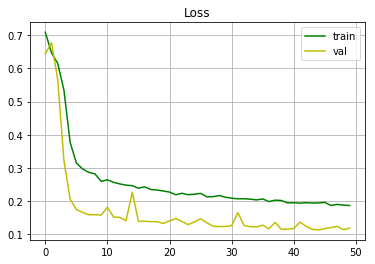

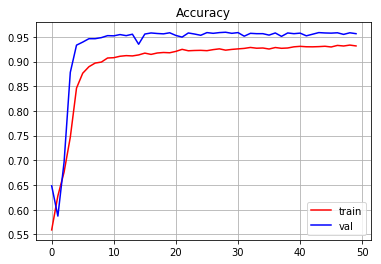

Done!


In [19]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [20]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 6s 2ms/step
Test loss: 0.10549193344664246
Test accuracy: 0.9629898403483309


In [21]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])

#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [22]:
y_pred.shape

(2756, 2)

In [23]:
accuracy

0.9629898403483309

In [24]:
np.save("y_pred_verynormal_exp5-dg.npy", y_pred)